In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))


True
1
0
NVIDIA GeForce RTX 4070 Ti SUPER


In [2]:
import os
import pandas as pd

def load_data(folder):
    data = []
    for label, sentiment in enumerate(['neg', 'pos']):
        sentiment_folder = os.path.join(folder, sentiment)
        for filename in os.listdir(sentiment_folder):
            if filename.endswith('.txt'):
                with open(os.path.join(sentiment_folder, filename), 'r', encoding='utf-8') as file:
                    text = file.read()
                    data.append({'text': text, 'label': sentiment})
    return pd.DataFrame(data)

path = "C:\\Users\\Andrea.Bagante\\Desktop\\text_classification_dataset\\aclImdb"
# Carica i dati di train
train_folder = os.path.join(path, 'train')
train_df = load_data(train_folder)

# Carica i dati di test
test_folder = os.path.join(path, 'test')
temp_df = load_data(test_folder)

# Mostra le prime righe di ciascun dataframe
print("Train DataFrame:")
print(train_df.head())
print("\nTest DataFrame:")
print(temp_df.head())

Train DataFrame:
                                                text label
0  Story of a man who has unnatural feelings for ...   neg
1  Airport '77 starts as a brand new luxury 747 p...   neg
2  This film lacked something I couldn't put my f...   neg
3  Sorry everyone,,, I know this is supposed to b...   neg
4  When I was little my parents took me along to ...   neg

Test DataFrame:
                                                text label
0  Once again Mr. Costner has dragged out a movie...   neg
1  This is an example of why the majority of acti...   neg
2  First of all I hate those moronic rappers, who...   neg
3  Not even the Beatles could write songs everyon...   neg
4  Brass pictures (movies is not a fitting word f...   neg


In [3]:
from sklearn.model_selection import train_test_split

val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [4]:
train_df = train_df.sample(frac=1, random_state=42)
train_df.reset_index(inplace=True)
train_df.drop(columns='index', inplace=True)
print(train_df.head())

                                                text label
0  Silent Night, Deadly Night 5 is the very last ...   neg
1  The idea ia a very short film with a lot of in...   pos
2  For me, this movie just seemed to fall on its ...   neg
3  Was this based on a comic-book? A video-game? ...   pos
4  Caution: May contain spoilers...<br /><br />I'...   pos


In [5]:
val_df.reset_index(inplace=True)
val_df.drop(columns='index', inplace=True)
print(val_df.head())


                                                text label
0  I hoped to learn something from this movie, bu...   neg
1  The title doesn't make much sense to me. I'm n...   neg
2  This movie was the worst movie I've ever seen....   neg
3  I remember watching this movie when it came ou...   pos
4  I rarely write reviews but this film simply de...   pos


In [6]:
test_df.reset_index(inplace=True)
test_df.drop(columns='index', inplace=True)
print(test_df.head())

                                                text label
0  I hate guns and have never murdered anyone, bu...   neg
1  If you are like me and you bought the new Tena...   pos
2  I have seen this movie several times, it sure ...   neg
3  There are many things to admire about this fil...   pos
4  It was so very long ago (1960), but I have nev...   pos


In [7]:
from datasets import Dataset, DatasetDict

# setup your sets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

c:\Users\Andrea.Bagante\AppData\Local\pypoetry\Cache\virtualenvs\text-classification-9VQE8-TT-py3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

# look at the set
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 12500
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12500
    })
})

In [9]:
def show_samples(dataset, num_samples=10, seed=42):
    sample = dataset["train"].shuffle(seed=seed).select(range(num_samples))
    for example in sample:
        print(f"\n'>> Text: {example['text']}'")
        print(f"'>> Label: {example['label']}'")


show_samples(dataset_dict)


'>> Text: Went to see this finnish film and I've got to say that it is one of the better films I've seen this year. The intrigue is made up of 5-6 different stories, all taking place the very same day in a small finnish town. The stories come together very nicely in the end, reminding, perhaps, a bit of the way Tarantino's movies are made. Most of the actors performed very well, which most certainly is needed in realistic dramas of this type. I especially enjoyed the acting by Sanna Hietala, the lead actress, and Juha Kukkonen. I noticed btw that IMDB has got the wrong information about Sanna. Her name, as you might have noticed in my review ;), is NOT Heikkilä, but Hietala.'
'>> Label: pos'

'>> Text: Four Eyed Monsters follows the relationship of a shy, reclusive videographer and an equally estranged struggling artist, who, both living in the Big Apple, develop an unlikely romance with the help of an internet dating site. This in itself is not so unusual, but what is, is their metho

In [10]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the LabelEncoder on all unique category labels in the DataFrame
label_encoder.fit(dataset_dict['train']['label'])

# Define a function to encode the categories in the dataset_dict
def encode_labels(example):
    # This will transform the text category to a numeric label
    return {'encoded_label': label_encoder.transform([example['label']])[0]}

# Apply the encode_labels function to each example in each split of dataset_dict
for split in dataset_dict:
    # The lambda function is replaced with the encode_labels function
    dataset_dict[split] = dataset_dict[split].map(encode_labels, batched=False)

# Check the number of unique labels
num_labels = len(label_encoder.classes_)
num_labels

Map: 100%|██████████| 12500/12500 [00:00<00:00, 16142.61 examples/s]


2

In [11]:
#model_name = "albert/albert-base-v2"
#model_name = 'bert-base-uncased'  # or any other suitable encoder model
model_name = 'microsoft/deberta-base'


In [12]:
from transformers import AutoConfig

unique_labels = sorted(list(set(dataset_dict['train']['label'])))
id2label = {i: label for i, label in enumerate(unique_labels)}
label2id = {label: i for i, label in enumerate(unique_labels)}

config = AutoConfig.from_pretrained(model_name)
config.id2label = id2label
config.label2id = label2id

# Verify the correct labels
print("ID to Label Mapping:", config.id2label)
print("Label to ID Mapping:", config.label2id)

ID to Label Mapping: {0: 'neg', 1: 'pos'}
Label to ID Mapping: {'neg': 0, 'pos': 1}


In [13]:
# from transformers import AlbertForSequenceClassification, AlbertTokenizer

# tokenizer = AlbertTokenizer.from_pretrained(model_name)
# model = AlbertForSequenceClassification.from_pretrained(model_name, config=config)


from transformers import AutoModelForSequenceClassification, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)#, num_labels=num_labels)

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
def filter_invalid_content(example):
    return isinstance(example['text'], str)

dataset = dataset_dict.filter(filter_invalid_content, batched=False)

def encode_data(batch):
    tokenized_inputs = tokenizer(batch["text"], padding=True, truncation=True, max_length=256)
    tokenized_inputs["labels"] = batch["encoded_label"]
    return tokenized_inputs

dataset_encoded = dataset.map(encode_data, batched=True)
dataset_encoded

Map: 100%|██████████| 12500/12500 [00:01<00:00, 7531.42 examples/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'encoded_label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 25000
    })
    validation: Dataset({
        features: ['text', 'label', 'encoded_label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 12500
    })
    test: Dataset({
        features: ['text', 'label', 'encoded_label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 12500
    })
})

In [15]:
dataset_encoded.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


In [16]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer)
     

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

label_encoder = LabelEncoder()
label_encoder.fit(unique_labels)

def per_label_accuracy(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    correct_predictions = cm.diagonal()
    label_totals = cm.sum(axis=1)
    per_label_acc = np.divide(correct_predictions, label_totals, out=np.zeros_like(correct_predictions, dtype=float), where=label_totals != 0)
    return dict(zip(labels, per_label_acc))

In [18]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    decoded_labels = label_encoder.inverse_transform(labels)
    decoded_preds = label_encoder.inverse_transform(preds)

    precision = precision_score(decoded_labels, decoded_preds, average='weighted')
    recall = recall_score(decoded_labels, decoded_preds, average='weighted')
    f1 = f1_score(decoded_labels, decoded_preds, average='weighted')
    acc = accuracy_score(decoded_labels, decoded_preds)

    labels_list = list(label_encoder.classes_)
    per_label_acc = per_label_accuracy(decoded_labels, decoded_preds, labels_list)

    per_label_acc_metrics = {}
    for label, accuracy in per_label_acc.items():
        label_key = f"accuracy_label_{label}"
        per_label_acc_metrics[label_key] = accuracy

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        **per_label_acc_metrics
    }

In [19]:
output_path = f"{model_name.split('/')[-1]}-classifier"

In [20]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir=output_path,
    num_train_epochs=3,
    warmup_steps=500,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    logging_steps=10,
    evaluation_strategy='steps',
    eval_steps=100,
    learning_rate=2e-5,
    save_steps=1000,
    gradient_accumulation_steps=2
)

c:\Users\Andrea.Bagante\AppData\Local\pypoetry\Cache\virtualenvs\text-classification-9VQE8-TT-py3.11\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [21]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_encoded['train'],
    eval_dataset=dataset_encoded['validation'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

C:\Users\Andrea.Bagante\AppData\Local\Temp\ipykernel_24960\69944262.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
  0%|          | 10/2343 [00:05<17:00,  2.29it/s]

{'loss': 1.3904, 'grad_norm': 1.4700833559036255, 'learning_rate': 4.0000000000000003e-07, 'epoch': 0.01}


  1%|          | 20/2343 [00:09<16:29,  2.35it/s]

{'loss': 1.3901, 'grad_norm': 0.960677981376648, 'learning_rate': 8.000000000000001e-07, 'epoch': 0.03}


  1%|▏         | 30/2343 [00:13<16:21,  2.36it/s]

{'loss': 1.394, 'grad_norm': 2.669725179672241, 'learning_rate': 1.2000000000000002e-06, 'epoch': 0.04}


  2%|▏         | 40/2343 [00:17<16:19,  2.35it/s]

{'loss': 1.3748, 'grad_norm': 2.075644016265869, 'learning_rate': 1.6000000000000001e-06, 'epoch': 0.05}


  2%|▏         | 50/2343 [00:22<16:18,  2.34it/s]

{'loss': 1.3852, 'grad_norm': 1.2421876192092896, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.06}


  3%|▎         | 60/2343 [00:26<16:09,  2.36it/s]

{'loss': 1.3787, 'grad_norm': 9.738408088684082, 'learning_rate': 2.4000000000000003e-06, 'epoch': 0.08}


  3%|▎         | 70/2343 [00:30<16:09,  2.34it/s]

{'loss': 1.3435, 'grad_norm': 6.811448097229004, 'learning_rate': 2.8000000000000003e-06, 'epoch': 0.09}


  3%|▎         | 80/2343 [00:34<16:04,  2.35it/s]

{'loss': 1.3314, 'grad_norm': 7.840959548950195, 'learning_rate': 3.2000000000000003e-06, 'epoch': 0.1}


  4%|▍         | 90/2343 [00:39<15:59,  2.35it/s]

{'loss': 1.3643, 'grad_norm': 6.757988929748535, 'learning_rate': 3.6000000000000003e-06, 'epoch': 0.12}


  4%|▍         | 100/2343 [00:43<15:58,  2.34it/s]

{'loss': 1.2253, 'grad_norm': 14.825971603393555, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.13}


c:\Users\Andrea.Bagante\AppData\Local\pypoetry\Cache\virtualenvs\text-classification-9VQE8-TT-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                  
  4%|▍         | 100/2343 [01:43<15:58,  2.34it/s]

{'eval_loss': 0.5651110410690308, 'eval_accuracy': 0.49536, 'eval_f1': 0.3281905756473358, 'eval_precision': 0.24538152959999998, 'eval_recall': 0.49536, 'eval_accuracy_label_neg': 1.0, 'eval_accuracy_label_pos': 0.0, 'eval_runtime': 59.5882, 'eval_samples_per_second': 209.773, 'eval_steps_per_second': 13.123, 'epoch': 0.13}


  5%|▍         | 110/2343 [01:47<42:59,  1.16s/it]   

{'loss': 1.1585, 'grad_norm': 9.761823654174805, 'learning_rate': 4.4e-06, 'epoch': 0.14}


  5%|▌         | 120/2343 [01:51<16:40,  2.22it/s]

{'loss': 1.0565, 'grad_norm': 6.233461380004883, 'learning_rate': 4.800000000000001e-06, 'epoch': 0.15}


  6%|▌         | 130/2343 [01:56<15:53,  2.32it/s]

{'loss': 0.9378, 'grad_norm': 24.286718368530273, 'learning_rate': 5.2e-06, 'epoch': 0.17}


  6%|▌         | 140/2343 [02:00<15:46,  2.33it/s]

{'loss': 0.9799, 'grad_norm': 10.131898880004883, 'learning_rate': 5.600000000000001e-06, 'epoch': 0.18}


  6%|▋         | 150/2343 [02:04<15:41,  2.33it/s]

{'loss': 1.0296, 'grad_norm': 5.950534820556641, 'learning_rate': 6e-06, 'epoch': 0.19}


  7%|▋         | 160/2343 [02:08<15:38,  2.33it/s]

{'loss': 0.9044, 'grad_norm': 124.32666015625, 'learning_rate': 6.4000000000000006e-06, 'epoch': 0.2}


  7%|▋         | 170/2343 [02:13<15:35,  2.32it/s]

{'loss': 0.9238, 'grad_norm': 31.80088996887207, 'learning_rate': 6.800000000000001e-06, 'epoch': 0.22}


  8%|▊         | 180/2343 [02:17<15:33,  2.32it/s]

{'loss': 0.9069, 'grad_norm': 6.279539108276367, 'learning_rate': 7.2000000000000005e-06, 'epoch': 0.23}


  8%|▊         | 190/2343 [02:21<15:26,  2.32it/s]

{'loss': 0.8652, 'grad_norm': 23.572509765625, 'learning_rate': 7.600000000000001e-06, 'epoch': 0.24}


  9%|▊         | 200/2343 [02:26<15:22,  2.32it/s]

{'loss': 0.7988, 'grad_norm': 51.835269927978516, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.26}


                                                  
  9%|▊         | 200/2343 [03:26<15:22,  2.32it/s]

{'eval_loss': 0.40104976296424866, 'eval_accuracy': 0.92152, 'eval_f1': 0.9215211426733706, 'eval_precision': 0.9216199662956364, 'eval_recall': 0.92152, 'eval_accuracy_label_neg': 0.9281330749354005, 'eval_accuracy_label_pos': 0.9150285351934052, 'eval_runtime': 59.8413, 'eval_samples_per_second': 208.886, 'eval_steps_per_second': 13.068, 'epoch': 0.26}


  9%|▉         | 210/2343 [03:30<41:05,  1.16s/it]   

{'loss': 0.7431, 'grad_norm': 24.973461151123047, 'learning_rate': 8.400000000000001e-06, 'epoch': 0.27}


  9%|▉         | 220/2343 [03:34<15:57,  2.22it/s]

{'loss': 0.6057, 'grad_norm': 12.729525566101074, 'learning_rate': 8.8e-06, 'epoch': 0.28}


 10%|▉         | 230/2343 [03:39<15:13,  2.31it/s]

{'loss': 0.4572, 'grad_norm': 39.21797180175781, 'learning_rate': 9.200000000000002e-06, 'epoch': 0.29}


 10%|█         | 240/2343 [03:43<15:07,  2.32it/s]

{'loss': 0.708, 'grad_norm': 13.821680068969727, 'learning_rate': 9.600000000000001e-06, 'epoch': 0.31}


 11%|█         | 250/2343 [03:47<15:03,  2.32it/s]

{'loss': 0.4806, 'grad_norm': 6.187958717346191, 'learning_rate': 1e-05, 'epoch': 0.32}


 11%|█         | 260/2343 [03:51<14:58,  2.32it/s]

{'loss': 0.4178, 'grad_norm': 8.465628623962402, 'learning_rate': 1.04e-05, 'epoch': 0.33}


 12%|█▏        | 270/2343 [03:56<14:53,  2.32it/s]

{'loss': 0.5711, 'grad_norm': 32.38379669189453, 'learning_rate': 1.0800000000000002e-05, 'epoch': 0.35}


 12%|█▏        | 280/2343 [04:00<14:50,  2.32it/s]

{'loss': 0.4568, 'grad_norm': 15.415760040283203, 'learning_rate': 1.1200000000000001e-05, 'epoch': 0.36}


 12%|█▏        | 290/2343 [04:04<14:46,  2.32it/s]

{'loss': 0.5659, 'grad_norm': 11.635177612304688, 'learning_rate': 1.16e-05, 'epoch': 0.37}


 13%|█▎        | 300/2343 [04:09<14:44,  2.31it/s]

{'loss': 0.5242, 'grad_norm': 4.114913463592529, 'learning_rate': 1.2e-05, 'epoch': 0.38}


                                                  
 13%|█▎        | 300/2343 [05:09<14:44,  2.31it/s]

{'eval_loss': 0.19559726119041443, 'eval_accuracy': 0.92784, 'eval_f1': 0.927769038575328, 'eval_precision': 0.9290599638572091, 'eval_recall': 0.92784, 'eval_accuracy_label_neg': 0.8998708010335917, 'eval_accuracy_label_pos': 0.955294863665187, 'eval_runtime': 60.0647, 'eval_samples_per_second': 208.109, 'eval_steps_per_second': 13.019, 'epoch': 0.38}


 13%|█▎        | 310/2343 [05:13<39:18,  1.16s/it]   

{'loss': 0.4194, 'grad_norm': 8.832245826721191, 'learning_rate': 1.2400000000000002e-05, 'epoch': 0.4}


 14%|█▎        | 320/2343 [05:17<15:17,  2.20it/s]

{'loss': 0.4765, 'grad_norm': 9.940662384033203, 'learning_rate': 1.2800000000000001e-05, 'epoch': 0.41}


 14%|█▍        | 330/2343 [05:22<14:34,  2.30it/s]

{'loss': 0.4219, 'grad_norm': 11.077191352844238, 'learning_rate': 1.3200000000000002e-05, 'epoch': 0.42}


 15%|█▍        | 340/2343 [05:26<14:28,  2.31it/s]

{'loss': 0.3226, 'grad_norm': 10.28187370300293, 'learning_rate': 1.3600000000000002e-05, 'epoch': 0.44}


 15%|█▍        | 350/2343 [05:30<14:21,  2.31it/s]

{'loss': 0.4303, 'grad_norm': 14.401262283325195, 'learning_rate': 1.4e-05, 'epoch': 0.45}


 15%|█▌        | 360/2343 [05:35<14:18,  2.31it/s]

{'loss': 0.3827, 'grad_norm': 7.0625739097595215, 'learning_rate': 1.4400000000000001e-05, 'epoch': 0.46}


 16%|█▌        | 370/2343 [05:39<14:14,  2.31it/s]

{'loss': 0.6194, 'grad_norm': 9.061018943786621, 'learning_rate': 1.48e-05, 'epoch': 0.47}


 16%|█▌        | 380/2343 [05:43<14:09,  2.31it/s]

{'loss': 0.299, 'grad_norm': 19.301965713500977, 'learning_rate': 1.5200000000000002e-05, 'epoch': 0.49}


 17%|█▋        | 390/2343 [05:48<14:08,  2.30it/s]

{'loss': 0.4616, 'grad_norm': 69.67082214355469, 'learning_rate': 1.5600000000000003e-05, 'epoch': 0.5}


 17%|█▋        | 400/2343 [05:52<14:00,  2.31it/s]

{'loss': 0.5508, 'grad_norm': 13.820547103881836, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.51}


                                                  
 17%|█▋        | 400/2343 [06:52<14:00,  2.31it/s]

{'eval_loss': 0.19233326613903046, 'eval_accuracy': 0.93272, 'eval_f1': 0.932712143450677, 'eval_precision': 0.9332062854487619, 'eval_recall': 0.93272, 'eval_accuracy_label_neg': 0.9486434108527132, 'eval_accuracy_label_pos': 0.9170894102726697, 'eval_runtime': 60.0297, 'eval_samples_per_second': 208.23, 'eval_steps_per_second': 13.027, 'epoch': 0.51}


 17%|█▋        | 410/2343 [06:56<37:19,  1.16s/it]  

{'loss': 0.5311, 'grad_norm': 9.805421829223633, 'learning_rate': 1.64e-05, 'epoch': 0.52}


 18%|█▊        | 420/2343 [07:01<14:29,  2.21it/s]

{'loss': 0.5884, 'grad_norm': 30.734315872192383, 'learning_rate': 1.6800000000000002e-05, 'epoch': 0.54}


 18%|█▊        | 430/2343 [07:05<13:46,  2.31it/s]

{'loss': 0.4538, 'grad_norm': 19.70610809326172, 'learning_rate': 1.72e-05, 'epoch': 0.55}


 19%|█▉        | 440/2343 [07:09<13:41,  2.32it/s]

{'loss': 0.3839, 'grad_norm': 28.793643951416016, 'learning_rate': 1.76e-05, 'epoch': 0.56}


 19%|█▉        | 450/2343 [07:14<13:39,  2.31it/s]

{'loss': 0.4446, 'grad_norm': 14.054117202758789, 'learning_rate': 1.8e-05, 'epoch': 0.58}


 20%|█▉        | 460/2343 [07:18<13:32,  2.32it/s]

{'loss': 0.3441, 'grad_norm': 14.259284019470215, 'learning_rate': 1.8400000000000003e-05, 'epoch': 0.59}


 20%|██        | 470/2343 [07:22<13:28,  2.32it/s]

{'loss': 0.5561, 'grad_norm': 8.941240310668945, 'learning_rate': 1.88e-05, 'epoch': 0.6}


 20%|██        | 480/2343 [07:27<13:22,  2.32it/s]

{'loss': 0.3728, 'grad_norm': 17.862342834472656, 'learning_rate': 1.9200000000000003e-05, 'epoch': 0.61}


 21%|██        | 490/2343 [07:31<13:20,  2.32it/s]

{'loss': 0.5559, 'grad_norm': 11.676239013671875, 'learning_rate': 1.9600000000000002e-05, 'epoch': 0.63}


 21%|██▏       | 500/2343 [07:35<13:15,  2.32it/s]

{'loss': 0.3622, 'grad_norm': 7.955653190612793, 'learning_rate': 2e-05, 'epoch': 0.64}


                                                  
 21%|██▏       | 500/2343 [08:35<13:15,  2.32it/s]

{'eval_loss': 0.22698542475700378, 'eval_accuracy': 0.91648, 'eval_f1': 0.9163151015384616, 'eval_precision': 0.9206352288283883, 'eval_recall': 0.91648, 'eval_accuracy_label_neg': 0.9654392764857881, 'eval_accuracy_label_pos': 0.868421052631579, 'eval_runtime': 59.9297, 'eval_samples_per_second': 208.578, 'eval_steps_per_second': 13.049, 'epoch': 0.64}


 22%|██▏       | 510/2343 [08:40<35:20,  1.16s/it]  

{'loss': 0.3845, 'grad_norm': 14.113615989685059, 'learning_rate': 1.9891481280520892e-05, 'epoch': 0.65}


 22%|██▏       | 520/2343 [08:44<13:45,  2.21it/s]

{'loss': 0.5704, 'grad_norm': 12.863367080688477, 'learning_rate': 1.978296256104178e-05, 'epoch': 0.67}


 23%|██▎       | 530/2343 [08:48<13:03,  2.31it/s]

{'loss': 0.4905, 'grad_norm': 7.033312797546387, 'learning_rate': 1.9674443841562673e-05, 'epoch': 0.68}


 23%|██▎       | 540/2343 [08:53<12:57,  2.32it/s]

{'loss': 0.3977, 'grad_norm': 9.308353424072266, 'learning_rate': 1.956592512208356e-05, 'epoch': 0.69}


 23%|██▎       | 550/2343 [08:57<12:54,  2.32it/s]

{'loss': 0.3739, 'grad_norm': 23.448755264282227, 'learning_rate': 1.945740640260445e-05, 'epoch': 0.7}


 24%|██▍       | 560/2343 [09:01<12:48,  2.32it/s]

{'loss': 0.3136, 'grad_norm': 6.642096519470215, 'learning_rate': 1.934888768312534e-05, 'epoch': 0.72}


 24%|██▍       | 570/2343 [09:06<12:44,  2.32it/s]

{'loss': 0.4328, 'grad_norm': 11.417130470275879, 'learning_rate': 1.924036896364623e-05, 'epoch': 0.73}


 25%|██▍       | 580/2343 [09:10<12:43,  2.31it/s]

{'loss': 0.4764, 'grad_norm': 6.610267162322998, 'learning_rate': 1.9131850244167122e-05, 'epoch': 0.74}


 25%|██▌       | 590/2343 [09:14<12:35,  2.32it/s]

{'loss': 0.4551, 'grad_norm': 15.35319709777832, 'learning_rate': 1.9023331524688013e-05, 'epoch': 0.75}


 26%|██▌       | 600/2343 [09:18<12:31,  2.32it/s]

{'loss': 0.2761, 'grad_norm': 4.263948440551758, 'learning_rate': 1.89148128052089e-05, 'epoch': 0.77}


                                                  
 26%|██▌       | 600/2343 [10:18<12:31,  2.32it/s]

{'eval_loss': 0.19516338407993317, 'eval_accuracy': 0.93392, 'eval_f1': 0.9339089074918804, 'eval_precision': 0.9340532799056059, 'eval_recall': 0.93392, 'eval_accuracy_label_neg': 0.9240956072351422, 'eval_accuracy_label_pos': 0.9435637285986049, 'eval_runtime': 59.9897, 'eval_samples_per_second': 208.369, 'eval_steps_per_second': 13.036, 'epoch': 0.77}


 26%|██▌       | 610/2343 [10:23<33:29,  1.16s/it]  

{'loss': 0.3461, 'grad_norm': 6.398813724517822, 'learning_rate': 1.880629408572979e-05, 'epoch': 0.78}


 26%|██▋       | 620/2343 [10:27<13:02,  2.20it/s]

{'loss': 0.3379, 'grad_norm': 13.033812522888184, 'learning_rate': 1.8697775366250677e-05, 'epoch': 0.79}


 27%|██▋       | 630/2343 [10:31<12:22,  2.31it/s]

{'loss': 0.48, 'grad_norm': 9.591526985168457, 'learning_rate': 1.8589256646771568e-05, 'epoch': 0.81}


 27%|██▋       | 640/2343 [10:36<12:17,  2.31it/s]

{'loss': 0.4545, 'grad_norm': 24.187849044799805, 'learning_rate': 1.8480737927292462e-05, 'epoch': 0.82}


 28%|██▊       | 650/2343 [10:40<12:12,  2.31it/s]

{'loss': 0.3463, 'grad_norm': 7.625249862670898, 'learning_rate': 1.837221920781335e-05, 'epoch': 0.83}


 28%|██▊       | 660/2343 [10:44<12:05,  2.32it/s]

{'loss': 0.4741, 'grad_norm': 8.718684196472168, 'learning_rate': 1.826370048833424e-05, 'epoch': 0.84}


 29%|██▊       | 670/2343 [10:49<12:00,  2.32it/s]

{'loss': 0.3858, 'grad_norm': 5.1166815757751465, 'learning_rate': 1.8155181768855127e-05, 'epoch': 0.86}


 29%|██▉       | 680/2343 [10:53<11:56,  2.32it/s]

{'loss': 0.3778, 'grad_norm': 6.568966388702393, 'learning_rate': 1.8046663049376017e-05, 'epoch': 0.87}


 29%|██▉       | 690/2343 [10:57<11:54,  2.31it/s]

{'loss': 0.4205, 'grad_norm': 11.765812873840332, 'learning_rate': 1.793814432989691e-05, 'epoch': 0.88}


 30%|██▉       | 700/2343 [11:02<11:47,  2.32it/s]

{'loss': 0.3213, 'grad_norm': 10.929938316345215, 'learning_rate': 1.7829625610417798e-05, 'epoch': 0.9}


                                                  
 30%|██▉       | 700/2343 [12:02<11:47,  2.32it/s]

{'eval_loss': 0.1634560227394104, 'eval_accuracy': 0.9408, 'eval_f1': 0.9408011776003106, 'eval_precision': 0.9408235977840904, 'eval_recall': 0.9408, 'eval_accuracy_label_neg': 0.9436369509043928, 'eval_accuracy_label_pos': 0.9380152187698161, 'eval_runtime': 59.7988, 'eval_samples_per_second': 209.034, 'eval_steps_per_second': 13.077, 'epoch': 0.9}


 30%|███       | 710/2343 [12:06<31:26,  1.16s/it]  

{'loss': 0.4375, 'grad_norm': 9.31325626373291, 'learning_rate': 1.772110689093869e-05, 'epoch': 0.91}


 31%|███       | 720/2343 [12:10<12:13,  2.21it/s]

{'loss': 0.423, 'grad_norm': 14.565400123596191, 'learning_rate': 1.761258817145958e-05, 'epoch': 0.92}


 31%|███       | 730/2343 [12:14<11:36,  2.32it/s]

{'loss': 0.3609, 'grad_norm': 8.865084648132324, 'learning_rate': 1.7504069451980466e-05, 'epoch': 0.93}


 32%|███▏      | 740/2343 [12:19<11:36,  2.30it/s]

{'loss': 0.4116, 'grad_norm': 11.649711608886719, 'learning_rate': 1.739555073250136e-05, 'epoch': 0.95}


 32%|███▏      | 750/2343 [12:23<11:30,  2.31it/s]

{'loss': 0.3986, 'grad_norm': 13.865185737609863, 'learning_rate': 1.7287032013022247e-05, 'epoch': 0.96}


 32%|███▏      | 760/2343 [12:27<11:27,  2.30it/s]

{'loss': 0.4599, 'grad_norm': 6.931880474090576, 'learning_rate': 1.7178513293543138e-05, 'epoch': 0.97}


 33%|███▎      | 770/2343 [12:32<11:22,  2.30it/s]

{'loss': 0.354, 'grad_norm': 11.859464645385742, 'learning_rate': 1.7069994574064028e-05, 'epoch': 0.99}


 33%|███▎      | 780/2343 [12:36<11:21,  2.30it/s]

{'loss': 0.3303, 'grad_norm': 11.82916259765625, 'learning_rate': 1.6961475854584915e-05, 'epoch': 1.0}


 34%|███▎      | 790/2343 [12:40<11:05,  2.33it/s]

{'loss': 0.3573, 'grad_norm': 11.03402328491211, 'learning_rate': 1.685295713510581e-05, 'epoch': 1.01}


 34%|███▍      | 800/2343 [12:45<11:10,  2.30it/s]

{'loss': 0.2486, 'grad_norm': 8.353581428527832, 'learning_rate': 1.6744438415626696e-05, 'epoch': 1.02}


                                                  
 34%|███▍      | 800/2343 [13:45<11:10,  2.30it/s]

{'eval_loss': 0.1924717128276825, 'eval_accuracy': 0.93848, 'eval_f1': 0.938480895734783, 'eval_precision': 0.9385812701625141, 'eval_recall': 0.93848, 'eval_accuracy_label_neg': 0.9452519379844961, 'eval_accuracy_label_pos': 0.9318325935320229, 'eval_runtime': 60.096, 'eval_samples_per_second': 208.001, 'eval_steps_per_second': 13.013, 'epoch': 1.02}


 35%|███▍      | 810/2343 [13:49<29:37,  1.16s/it]  

{'loss': 0.3538, 'grad_norm': 24.720121383666992, 'learning_rate': 1.6635919696147587e-05, 'epoch': 1.04}


 35%|███▍      | 820/2343 [13:53<11:31,  2.20it/s]

{'loss': 0.337, 'grad_norm': 16.518451690673828, 'learning_rate': 1.6527400976668477e-05, 'epoch': 1.05}


 35%|███▌      | 830/2343 [13:58<10:54,  2.31it/s]

{'loss': 0.2291, 'grad_norm': 28.064802169799805, 'learning_rate': 1.6418882257189364e-05, 'epoch': 1.06}


 36%|███▌      | 840/2343 [14:02<10:49,  2.31it/s]

{'loss': 0.3503, 'grad_norm': 19.418087005615234, 'learning_rate': 1.6310363537710255e-05, 'epoch': 1.07}


 36%|███▋      | 850/2343 [14:06<10:45,  2.31it/s]

{'loss': 0.1483, 'grad_norm': 11.06318187713623, 'learning_rate': 1.620184481823115e-05, 'epoch': 1.09}


 37%|███▋      | 860/2343 [14:11<10:39,  2.32it/s]

{'loss': 0.3393, 'grad_norm': 46.498008728027344, 'learning_rate': 1.6093326098752036e-05, 'epoch': 1.1}


 37%|███▋      | 870/2343 [14:15<10:35,  2.32it/s]

{'loss': 0.2506, 'grad_norm': 4.911871910095215, 'learning_rate': 1.5984807379272926e-05, 'epoch': 1.11}


 38%|███▊      | 880/2343 [14:19<10:31,  2.32it/s]

{'loss': 0.2822, 'grad_norm': 12.054292678833008, 'learning_rate': 1.5876288659793813e-05, 'epoch': 1.13}


 38%|███▊      | 890/2343 [14:24<10:26,  2.32it/s]

{'loss': 0.2432, 'grad_norm': 9.25016975402832, 'learning_rate': 1.5767769940314704e-05, 'epoch': 1.14}


 38%|███▊      | 900/2343 [14:28<10:22,  2.32it/s]

{'loss': 0.246, 'grad_norm': 30.03265380859375, 'learning_rate': 1.5659251220835598e-05, 'epoch': 1.15}


                                                  
 38%|███▊      | 900/2343 [15:28<10:22,  2.32it/s]

{'eval_loss': 0.19849997758865356, 'eval_accuracy': 0.92912, 'eval_f1': 0.9290607233012177, 'eval_precision': 0.9311464964977884, 'eval_recall': 0.92912, 'eval_accuracy_label_neg': 0.9626937984496124, 'eval_accuracy_label_pos': 0.8961636017755231, 'eval_runtime': 59.943, 'eval_samples_per_second': 208.531, 'eval_steps_per_second': 13.046, 'epoch': 1.15}


 39%|███▉      | 910/2343 [15:32<27:41,  1.16s/it]  

{'loss': 0.2673, 'grad_norm': 24.754295349121094, 'learning_rate': 1.5550732501356485e-05, 'epoch': 1.16}


 39%|███▉      | 920/2343 [15:37<10:48,  2.20it/s]

{'loss': 0.5015, 'grad_norm': 4.342642307281494, 'learning_rate': 1.5442213781877375e-05, 'epoch': 1.18}


 40%|███▉      | 930/2343 [15:41<10:14,  2.30it/s]

{'loss': 0.4166, 'grad_norm': 13.014602661132812, 'learning_rate': 1.5333695062398263e-05, 'epoch': 1.19}


 40%|████      | 940/2343 [15:45<10:08,  2.31it/s]

{'loss': 0.4397, 'grad_norm': 13.203770637512207, 'learning_rate': 1.5225176342919155e-05, 'epoch': 1.2}


 41%|████      | 950/2343 [15:50<10:03,  2.31it/s]

{'loss': 0.3565, 'grad_norm': 18.279579162597656, 'learning_rate': 1.5116657623440045e-05, 'epoch': 1.21}


 41%|████      | 960/2343 [15:54<09:58,  2.31it/s]

{'loss': 0.2919, 'grad_norm': 4.013239860534668, 'learning_rate': 1.5008138903960934e-05, 'epoch': 1.23}


 41%|████▏     | 970/2343 [15:58<09:53,  2.31it/s]

{'loss': 0.1879, 'grad_norm': 14.337512969970703, 'learning_rate': 1.4899620184481825e-05, 'epoch': 1.24}


 42%|████▏     | 980/2343 [16:03<09:49,  2.31it/s]

{'loss': 0.3574, 'grad_norm': 30.468591690063477, 'learning_rate': 1.4791101465002715e-05, 'epoch': 1.25}


 42%|████▏     | 990/2343 [16:07<09:43,  2.32it/s]

{'loss': 0.3398, 'grad_norm': 30.136669158935547, 'learning_rate': 1.4682582745523604e-05, 'epoch': 1.27}


 43%|████▎     | 1000/2343 [16:11<09:42,  2.31it/s]

{'loss': 0.4377, 'grad_norm': 17.420366287231445, 'learning_rate': 1.4574064026044494e-05, 'epoch': 1.28}


                                                   
 43%|████▎     | 1000/2343 [17:11<09:42,  2.31it/s]

{'eval_loss': 0.21387653052806854, 'eval_accuracy': 0.9368, 'eval_f1': 0.9367969857742201, 'eval_precision': 0.9371087499734966, 'eval_recall': 0.9368, 'eval_accuracy_label_neg': 0.9492894056847545, 'eval_accuracy_label_pos': 0.9245402663284717, 'eval_runtime': 60.1302, 'eval_samples_per_second': 207.882, 'eval_steps_per_second': 13.005, 'epoch': 1.28}


 43%|████▎     | 1010/2343 [17:17<26:05,  1.17s/it]  

{'loss': 0.3746, 'grad_norm': 6.215121269226074, 'learning_rate': 1.4465545306565383e-05, 'epoch': 1.29}


 44%|████▎     | 1020/2343 [17:21<10:00,  2.20it/s]

{'loss': 0.2097, 'grad_norm': 21.7318115234375, 'learning_rate': 1.4357026587086274e-05, 'epoch': 1.3}


 44%|████▍     | 1030/2343 [17:26<09:29,  2.31it/s]

{'loss': 0.2276, 'grad_norm': 14.909592628479004, 'learning_rate': 1.4248507867607164e-05, 'epoch': 1.32}


 44%|████▍     | 1040/2343 [17:30<09:23,  2.31it/s]

{'loss': 0.2611, 'grad_norm': 16.10433578491211, 'learning_rate': 1.4139989148128053e-05, 'epoch': 1.33}


 45%|████▍     | 1050/2343 [17:34<09:19,  2.31it/s]

{'loss': 0.2127, 'grad_norm': 3.442399740219116, 'learning_rate': 1.4031470428648943e-05, 'epoch': 1.34}


 45%|████▌     | 1060/2343 [17:39<09:14,  2.31it/s]

{'loss': 0.3982, 'grad_norm': 17.547996520996094, 'learning_rate': 1.3922951709169832e-05, 'epoch': 1.36}


 46%|████▌     | 1070/2343 [17:43<09:11,  2.31it/s]

{'loss': 0.2929, 'grad_norm': 11.651577949523926, 'learning_rate': 1.3814432989690723e-05, 'epoch': 1.37}


 46%|████▌     | 1080/2343 [17:47<09:06,  2.31it/s]

{'loss': 0.2293, 'grad_norm': 5.026354789733887, 'learning_rate': 1.3705914270211613e-05, 'epoch': 1.38}


 47%|████▋     | 1090/2343 [17:51<09:02,  2.31it/s]

{'loss': 0.2591, 'grad_norm': 19.780183792114258, 'learning_rate': 1.3597395550732502e-05, 'epoch': 1.39}


 47%|████▋     | 1100/2343 [17:56<08:59,  2.30it/s]

{'loss': 0.3886, 'grad_norm': 29.22057342529297, 'learning_rate': 1.3488876831253393e-05, 'epoch': 1.41}


                                                   
 47%|████▋     | 1100/2343 [18:56<08:59,  2.30it/s]

{'eval_loss': 0.19191960990428925, 'eval_accuracy': 0.94216, 'eval_f1': 0.9421601254896712, 'eval_precision': 0.942314252569959, 'eval_recall': 0.94216, 'eval_accuracy_label_neg': 0.9507428940568475, 'eval_accuracy_label_pos': 0.9337349397590361, 'eval_runtime': 60.142, 'eval_samples_per_second': 207.841, 'eval_steps_per_second': 13.003, 'epoch': 1.41}


 47%|████▋     | 1110/2343 [19:00<23:53,  1.16s/it]  

{'loss': 0.3558, 'grad_norm': 5.777237892150879, 'learning_rate': 1.3380358111774283e-05, 'epoch': 1.42}


 48%|████▊     | 1120/2343 [19:05<09:14,  2.21it/s]

{'loss': 0.4504, 'grad_norm': 4.428515434265137, 'learning_rate': 1.3271839392295172e-05, 'epoch': 1.43}


 48%|████▊     | 1130/2343 [19:09<08:46,  2.30it/s]

{'loss': 0.296, 'grad_norm': 15.118349075317383, 'learning_rate': 1.3163320672816062e-05, 'epoch': 1.45}


 49%|████▊     | 1140/2343 [19:13<08:41,  2.31it/s]

{'loss': 0.225, 'grad_norm': 9.235675811767578, 'learning_rate': 1.3054801953336951e-05, 'epoch': 1.46}


 49%|████▉     | 1150/2343 [19:18<08:35,  2.31it/s]

{'loss': 0.3544, 'grad_norm': 11.938088417053223, 'learning_rate': 1.2946283233857842e-05, 'epoch': 1.47}


 50%|████▉     | 1160/2343 [19:22<08:31,  2.31it/s]

{'loss': 0.2592, 'grad_norm': 8.356720924377441, 'learning_rate': 1.2837764514378732e-05, 'epoch': 1.48}


 50%|████▉     | 1170/2343 [19:26<08:29,  2.30it/s]

{'loss': 0.262, 'grad_norm': 5.714118957519531, 'learning_rate': 1.2729245794899621e-05, 'epoch': 1.5}


 50%|█████     | 1180/2343 [19:31<08:22,  2.32it/s]

{'loss': 0.3166, 'grad_norm': 2.790334701538086, 'learning_rate': 1.2620727075420511e-05, 'epoch': 1.51}


 51%|█████     | 1190/2343 [19:35<08:17,  2.32it/s]

{'loss': 0.2542, 'grad_norm': 5.623571872711182, 'learning_rate': 1.25122083559414e-05, 'epoch': 1.52}


 51%|█████     | 1200/2343 [19:39<08:13,  2.32it/s]

{'loss': 0.2478, 'grad_norm': 6.566930294036865, 'learning_rate': 1.240368963646229e-05, 'epoch': 1.53}


                                                   
 51%|█████     | 1200/2343 [20:39<08:13,  2.32it/s]

{'eval_loss': 0.1652011275291443, 'eval_accuracy': 0.9424, 'eval_f1': 0.9423969397482989, 'eval_precision': 0.9424240445556658, 'eval_recall': 0.9424, 'eval_accuracy_label_neg': 0.9378229974160207, 'eval_accuracy_label_pos': 0.9468928344958782, 'eval_runtime': 60.1817, 'eval_samples_per_second': 207.704, 'eval_steps_per_second': 12.994, 'epoch': 1.53}


 52%|█████▏    | 1210/2343 [20:44<21:59,  1.16s/it]  

{'loss': 0.2699, 'grad_norm': 14.048286437988281, 'learning_rate': 1.2295170916983181e-05, 'epoch': 1.55}


 52%|█████▏    | 1220/2343 [20:48<08:29,  2.20it/s]

{'loss': 0.38, 'grad_norm': 5.729091167449951, 'learning_rate': 1.218665219750407e-05, 'epoch': 1.56}


 52%|█████▏    | 1230/2343 [20:53<08:05,  2.29it/s]

{'loss': 0.3555, 'grad_norm': 7.132800579071045, 'learning_rate': 1.207813347802496e-05, 'epoch': 1.57}


 53%|█████▎    | 1240/2343 [20:57<07:57,  2.31it/s]

{'loss': 0.2878, 'grad_norm': 11.108455657958984, 'learning_rate': 1.1969614758545851e-05, 'epoch': 1.59}


 53%|█████▎    | 1250/2343 [21:01<07:51,  2.32it/s]

{'loss': 0.2371, 'grad_norm': 6.073157787322998, 'learning_rate': 1.186109603906674e-05, 'epoch': 1.6}


 54%|█████▍    | 1260/2343 [21:05<07:48,  2.31it/s]

{'loss': 0.2887, 'grad_norm': 39.85442352294922, 'learning_rate': 1.175257731958763e-05, 'epoch': 1.61}


 54%|█████▍    | 1270/2343 [21:10<07:43,  2.32it/s]

{'loss': 0.4663, 'grad_norm': 29.270788192749023, 'learning_rate': 1.1644058600108519e-05, 'epoch': 1.62}


 55%|█████▍    | 1280/2343 [21:14<07:38,  2.32it/s]

{'loss': 0.3174, 'grad_norm': 5.953062057495117, 'learning_rate': 1.153553988062941e-05, 'epoch': 1.64}


 55%|█████▌    | 1290/2343 [21:18<07:33,  2.32it/s]

{'loss': 0.2476, 'grad_norm': 7.881698131561279, 'learning_rate': 1.14270211611503e-05, 'epoch': 1.65}


 55%|█████▌    | 1300/2343 [21:23<07:30,  2.32it/s]

{'loss': 0.2004, 'grad_norm': 16.15561866760254, 'learning_rate': 1.1318502441671189e-05, 'epoch': 1.66}


                                                   
 55%|█████▌    | 1300/2343 [22:23<07:30,  2.32it/s]

{'eval_loss': 0.1794842928647995, 'eval_accuracy': 0.93808, 'eval_f1': 0.938066416809762, 'eval_precision': 0.9388160654745651, 'eval_recall': 0.93808, 'eval_accuracy_label_neg': 0.9578488372093024, 'eval_accuracy_label_pos': 0.9186746987951807, 'eval_runtime': 60.0491, 'eval_samples_per_second': 208.163, 'eval_steps_per_second': 13.023, 'epoch': 1.66}


 56%|█████▌    | 1310/2343 [22:27<19:56,  1.16s/it]  

{'loss': 0.2483, 'grad_norm': 21.727725982666016, 'learning_rate': 1.120998372219208e-05, 'epoch': 1.68}


 56%|█████▋    | 1320/2343 [22:31<07:44,  2.20it/s]

{'loss': 0.4406, 'grad_norm': 21.24855613708496, 'learning_rate': 1.1101465002712968e-05, 'epoch': 1.69}


 57%|█████▋    | 1330/2343 [22:36<07:19,  2.30it/s]

{'loss': 0.2482, 'grad_norm': 10.072214126586914, 'learning_rate': 1.0992946283233859e-05, 'epoch': 1.7}


 57%|█████▋    | 1340/2343 [22:40<07:14,  2.31it/s]

{'loss': 0.3465, 'grad_norm': 9.254075050354004, 'learning_rate': 1.088442756375475e-05, 'epoch': 1.71}


 58%|█████▊    | 1350/2343 [22:44<07:09,  2.31it/s]

{'loss': 0.3202, 'grad_norm': 10.130105018615723, 'learning_rate': 1.0775908844275638e-05, 'epoch': 1.73}


 58%|█████▊    | 1360/2343 [22:49<07:08,  2.30it/s]

{'loss': 0.2371, 'grad_norm': 1.2884273529052734, 'learning_rate': 1.0667390124796528e-05, 'epoch': 1.74}


 58%|█████▊    | 1370/2343 [22:53<07:06,  2.28it/s]

{'loss': 0.2155, 'grad_norm': 7.727924823760986, 'learning_rate': 1.0558871405317419e-05, 'epoch': 1.75}


 59%|█████▉    | 1380/2343 [22:58<07:01,  2.29it/s]

{'loss': 0.2202, 'grad_norm': 22.574159622192383, 'learning_rate': 1.0450352685838308e-05, 'epoch': 1.77}


 59%|█████▉    | 1390/2343 [23:02<06:57,  2.28it/s]

{'loss': 0.3412, 'grad_norm': 10.169411659240723, 'learning_rate': 1.0341833966359198e-05, 'epoch': 1.78}


 60%|█████▉    | 1400/2343 [23:06<06:48,  2.31it/s]

{'loss': 0.3106, 'grad_norm': 16.62278938293457, 'learning_rate': 1.0233315246880087e-05, 'epoch': 1.79}


                                                   
 60%|█████▉    | 1400/2343 [24:06<06:48,  2.31it/s]

{'eval_loss': 0.17698581516742706, 'eval_accuracy': 0.9384, 'eval_f1': 0.9383484561052466, 'eval_precision': 0.9394400582975825, 'eval_recall': 0.9384, 'eval_accuracy_label_neg': 0.912952196382429, 'eval_accuracy_label_pos': 0.9633798351299937, 'eval_runtime': 60.093, 'eval_samples_per_second': 208.011, 'eval_steps_per_second': 13.013, 'epoch': 1.79}


 60%|██████    | 1410/2343 [24:11<18:03,  1.16s/it]  

{'loss': 0.2438, 'grad_norm': 8.54443073272705, 'learning_rate': 1.0124796527400978e-05, 'epoch': 1.8}


 61%|██████    | 1420/2343 [24:15<06:58,  2.21it/s]

{'loss': 0.3805, 'grad_norm': 9.472867012023926, 'learning_rate': 1.0016277807921868e-05, 'epoch': 1.82}


 61%|██████    | 1430/2343 [24:19<06:36,  2.30it/s]

{'loss': 0.2405, 'grad_norm': 8.611418724060059, 'learning_rate': 9.907759088442757e-06, 'epoch': 1.83}


 61%|██████▏   | 1440/2343 [24:24<06:31,  2.31it/s]

{'loss': 0.2559, 'grad_norm': 7.464064598083496, 'learning_rate': 9.799240368963647e-06, 'epoch': 1.84}


 62%|██████▏   | 1450/2343 [24:28<06:27,  2.30it/s]

{'loss': 0.2465, 'grad_norm': 10.145992279052734, 'learning_rate': 9.690721649484536e-06, 'epoch': 1.85}


 62%|██████▏   | 1460/2343 [24:32<06:21,  2.31it/s]

{'loss': 0.3194, 'grad_norm': 15.311802864074707, 'learning_rate': 9.582202930005427e-06, 'epoch': 1.87}


 63%|██████▎   | 1470/2343 [24:37<06:17,  2.31it/s]

{'loss': 0.2699, 'grad_norm': 8.089759826660156, 'learning_rate': 9.473684210526315e-06, 'epoch': 1.88}


 63%|██████▎   | 1480/2343 [24:41<06:12,  2.32it/s]

{'loss': 0.2512, 'grad_norm': 13.736751556396484, 'learning_rate': 9.365165491047206e-06, 'epoch': 1.89}


 64%|██████▎   | 1490/2343 [24:45<06:08,  2.32it/s]

{'loss': 0.1293, 'grad_norm': 3.8792824745178223, 'learning_rate': 9.256646771568096e-06, 'epoch': 1.91}


 64%|██████▍   | 1500/2343 [24:50<06:03,  2.32it/s]

{'loss': 0.3261, 'grad_norm': 21.23089599609375, 'learning_rate': 9.148128052088985e-06, 'epoch': 1.92}


                                                   
 64%|██████▍   | 1500/2343 [25:50<06:03,  2.32it/s]

{'eval_loss': 0.1869107037782669, 'eval_accuracy': 0.94256, 'eval_f1': 0.9425263342737534, 'eval_precision': 0.9432484461762063, 'eval_recall': 0.94256, 'eval_accuracy_label_neg': 0.9218346253229974, 'eval_accuracy_label_pos': 0.9629042485732403, 'eval_runtime': 59.976, 'eval_samples_per_second': 208.417, 'eval_steps_per_second': 13.039, 'epoch': 1.92}


 64%|██████▍   | 1510/2343 [25:54<16:04,  1.16s/it]  

{'loss': 0.2238, 'grad_norm': 5.537050247192383, 'learning_rate': 9.039609332609876e-06, 'epoch': 1.93}


 65%|██████▍   | 1520/2343 [25:58<06:12,  2.21it/s]

{'loss': 0.4272, 'grad_norm': 3.546929359436035, 'learning_rate': 8.931090613130766e-06, 'epoch': 1.94}


 65%|██████▌   | 1530/2343 [26:03<05:52,  2.30it/s]

{'loss': 0.4489, 'grad_norm': 24.706340789794922, 'learning_rate': 8.822571893651655e-06, 'epoch': 1.96}


 66%|██████▌   | 1540/2343 [26:07<05:47,  2.31it/s]

{'loss': 0.3891, 'grad_norm': 6.698309898376465, 'learning_rate': 8.714053174172546e-06, 'epoch': 1.97}


 66%|██████▌   | 1550/2343 [26:11<05:42,  2.32it/s]

{'loss': 0.3094, 'grad_norm': 1.3013560771942139, 'learning_rate': 8.605534454693434e-06, 'epoch': 1.98}


 67%|██████▋   | 1560/2343 [26:16<05:38,  2.31it/s]

{'loss': 0.2631, 'grad_norm': 4.985429286956787, 'learning_rate': 8.497015735214325e-06, 'epoch': 2.0}


 67%|██████▋   | 1570/2343 [26:20<05:25,  2.38it/s]

{'loss': 0.1073, 'grad_norm': 5.181309700012207, 'learning_rate': 8.388497015735215e-06, 'epoch': 2.01}


 67%|██████▋   | 1580/2343 [26:24<05:29,  2.32it/s]

{'loss': 0.1252, 'grad_norm': 7.158130168914795, 'learning_rate': 8.279978296256104e-06, 'epoch': 2.02}


 68%|██████▊   | 1590/2343 [26:28<05:25,  2.32it/s]

{'loss': 0.2324, 'grad_norm': 22.56765365600586, 'learning_rate': 8.171459576776995e-06, 'epoch': 2.03}


 68%|██████▊   | 1600/2343 [26:33<05:20,  2.32it/s]

{'loss': 0.1486, 'grad_norm': 30.26712417602539, 'learning_rate': 8.062940857297883e-06, 'epoch': 2.05}


                                                   
 68%|██████▊   | 1600/2343 [27:33<05:20,  2.32it/s]

{'eval_loss': 0.22943253815174103, 'eval_accuracy': 0.93832, 'eval_f1': 0.9383013402951647, 'eval_precision': 0.9392457956968231, 'eval_recall': 0.93832, 'eval_accuracy_label_neg': 0.960594315245478, 'eval_accuracy_label_pos': 0.9164552948636652, 'eval_runtime': 60.1487, 'eval_samples_per_second': 207.818, 'eval_steps_per_second': 13.001, 'epoch': 2.05}


 69%|██████▊   | 1610/2343 [27:37<14:11,  1.16s/it]  

{'loss': 0.2887, 'grad_norm': 7.822559833526611, 'learning_rate': 7.954422137818774e-06, 'epoch': 2.06}


 69%|██████▉   | 1620/2343 [27:41<05:28,  2.20it/s]

{'loss': 0.1403, 'grad_norm': 5.542515277862549, 'learning_rate': 7.845903418339664e-06, 'epoch': 2.07}


 70%|██████▉   | 1630/2343 [27:46<05:09,  2.30it/s]

{'loss': 0.1441, 'grad_norm': 11.353352546691895, 'learning_rate': 7.737384698860553e-06, 'epoch': 2.08}


 70%|██████▉   | 1640/2343 [27:50<05:04,  2.31it/s]

{'loss': 0.1654, 'grad_norm': 3.678636074066162, 'learning_rate': 7.628865979381444e-06, 'epoch': 2.1}


 70%|███████   | 1650/2343 [27:54<05:00,  2.31it/s]

{'loss': 0.1042, 'grad_norm': 7.719171047210693, 'learning_rate': 7.520347259902334e-06, 'epoch': 2.11}


 71%|███████   | 1660/2343 [27:59<04:55,  2.31it/s]

{'loss': 0.1858, 'grad_norm': 2.2660508155822754, 'learning_rate': 7.411828540423224e-06, 'epoch': 2.12}


 71%|███████▏  | 1670/2343 [28:03<04:51,  2.31it/s]

{'loss': 0.1137, 'grad_norm': 19.13571548461914, 'learning_rate': 7.303309820944114e-06, 'epoch': 2.14}


 72%|███████▏  | 1680/2343 [28:07<04:46,  2.31it/s]

{'loss': 0.1301, 'grad_norm': 5.415517330169678, 'learning_rate': 7.194791101465003e-06, 'epoch': 2.15}


 72%|███████▏  | 1690/2343 [28:12<04:44,  2.30it/s]

{'loss': 0.0874, 'grad_norm': 0.21596162021160126, 'learning_rate': 7.086272381985894e-06, 'epoch': 2.16}


 73%|███████▎  | 1700/2343 [28:16<04:39,  2.30it/s]

{'loss': 0.2714, 'grad_norm': 19.398611068725586, 'learning_rate': 6.977753662506783e-06, 'epoch': 2.17}


                                                   
 73%|███████▎  | 1700/2343 [29:16<04:39,  2.30it/s]

{'eval_loss': 0.2395351529121399, 'eval_accuracy': 0.94184, 'eval_f1': 0.9418028636888519, 'eval_precision': 0.9426016753179247, 'eval_recall': 0.94184, 'eval_accuracy_label_neg': 0.9200581395348837, 'eval_accuracy_label_pos': 0.9632213062777425, 'eval_runtime': 60.0292, 'eval_samples_per_second': 208.232, 'eval_steps_per_second': 13.027, 'epoch': 2.17}


 73%|███████▎  | 1710/2343 [29:20<12:13,  1.16s/it]  

{'loss': 0.1517, 'grad_norm': 1.9123632907867432, 'learning_rate': 6.869234943027673e-06, 'epoch': 2.19}


 73%|███████▎  | 1720/2343 [29:25<04:42,  2.20it/s]

{'loss': 0.1696, 'grad_norm': 19.946025848388672, 'learning_rate': 6.760716223548563e-06, 'epoch': 2.2}


 74%|███████▍  | 1730/2343 [29:29<04:25,  2.31it/s]

{'loss': 0.0927, 'grad_norm': 4.3042311668396, 'learning_rate': 6.652197504069452e-06, 'epoch': 2.21}


 74%|███████▍  | 1740/2343 [29:33<04:20,  2.32it/s]

{'loss': 0.1952, 'grad_norm': 14.350210189819336, 'learning_rate': 6.543678784590343e-06, 'epoch': 2.23}


 75%|███████▍  | 1750/2343 [29:38<04:15,  2.32it/s]

{'loss': 0.2831, 'grad_norm': 7.65228271484375, 'learning_rate': 6.4351600651112325e-06, 'epoch': 2.24}


 75%|███████▌  | 1760/2343 [29:42<04:12,  2.31it/s]

{'loss': 0.1233, 'grad_norm': 10.780014991760254, 'learning_rate': 6.326641345632122e-06, 'epoch': 2.25}


 76%|███████▌  | 1770/2343 [29:46<04:07,  2.31it/s]

{'loss': 0.2754, 'grad_norm': 17.79026222229004, 'learning_rate': 6.218122626153012e-06, 'epoch': 2.26}


 76%|███████▌  | 1780/2343 [29:51<04:04,  2.30it/s]

{'loss': 0.1209, 'grad_norm': 2.620042562484741, 'learning_rate': 6.109603906673902e-06, 'epoch': 2.28}


 76%|███████▋  | 1790/2343 [29:55<03:59,  2.31it/s]

{'loss': 0.2155, 'grad_norm': 23.255399703979492, 'learning_rate': 6.001085187194792e-06, 'epoch': 2.29}


 77%|███████▋  | 1800/2343 [29:59<03:55,  2.31it/s]

{'loss': 0.1576, 'grad_norm': 21.328214645385742, 'learning_rate': 5.8925664677156816e-06, 'epoch': 2.3}


                                                   
 77%|███████▋  | 1800/2343 [30:59<03:55,  2.31it/s]

{'eval_loss': 0.20103128254413605, 'eval_accuracy': 0.94432, 'eval_f1': 0.9443195509508537, 'eval_precision': 0.9443203107593459, 'eval_recall': 0.94432, 'eval_accuracy_label_neg': 0.9429909560723514, 'eval_accuracy_label_pos': 0.9456246036778694, 'eval_runtime': 60.0, 'eval_samples_per_second': 208.333, 'eval_steps_per_second': 13.033, 'epoch': 2.3}


 77%|███████▋  | 1810/2343 [31:04<10:17,  1.16s/it]  

{'loss': 0.1752, 'grad_norm': 11.87192440032959, 'learning_rate': 5.784047748236571e-06, 'epoch': 2.31}


 78%|███████▊  | 1820/2343 [31:08<03:57,  2.20it/s]

{'loss': 0.107, 'grad_norm': 2.6897644996643066, 'learning_rate': 5.675529028757462e-06, 'epoch': 2.33}


 78%|███████▊  | 1830/2343 [31:12<03:41,  2.32it/s]

{'loss': 0.1732, 'grad_norm': 1.021921992301941, 'learning_rate': 5.567010309278351e-06, 'epoch': 2.34}


 79%|███████▊  | 1840/2343 [31:17<03:38,  2.30it/s]

{'loss': 0.1612, 'grad_norm': 0.31332314014434814, 'learning_rate': 5.458491589799241e-06, 'epoch': 2.35}


 79%|███████▉  | 1850/2343 [31:21<03:33,  2.31it/s]

{'loss': 0.2403, 'grad_norm': 0.7981016039848328, 'learning_rate': 5.349972870320131e-06, 'epoch': 2.37}


 79%|███████▉  | 1860/2343 [31:25<03:28,  2.31it/s]

{'loss': 0.1931, 'grad_norm': 0.15848514437675476, 'learning_rate': 5.241454150841021e-06, 'epoch': 2.38}


 80%|███████▉  | 1870/2343 [31:30<03:24,  2.31it/s]

{'loss': 0.2367, 'grad_norm': 32.95052719116211, 'learning_rate': 5.132935431361911e-06, 'epoch': 2.39}


 80%|████████  | 1880/2343 [31:34<03:20,  2.31it/s]

{'loss': 0.245, 'grad_norm': 16.95728302001953, 'learning_rate': 5.0244167118828005e-06, 'epoch': 2.4}


 81%|████████  | 1890/2343 [31:38<03:17,  2.30it/s]

{'loss': 0.1756, 'grad_norm': 24.122108459472656, 'learning_rate': 4.91589799240369e-06, 'epoch': 2.42}


 81%|████████  | 1900/2343 [31:43<03:11,  2.31it/s]

{'loss': 0.2072, 'grad_norm': 4.8040995597839355, 'learning_rate': 4.80737927292458e-06, 'epoch': 2.43}


                                                   
 81%|████████  | 1900/2343 [32:43<03:11,  2.31it/s]

{'eval_loss': 0.208912193775177, 'eval_accuracy': 0.94464, 'eval_f1': 0.944638060961795, 'eval_precision': 0.9446517956092416, 'eval_recall': 0.94464, 'eval_accuracy_label_neg': 0.9412144702842378, 'eval_accuracy_label_pos': 0.948002536461636, 'eval_runtime': 60.1525, 'eval_samples_per_second': 207.805, 'eval_steps_per_second': 13.0, 'epoch': 2.43}


 82%|████████▏ | 1910/2343 [32:47<08:23,  1.16s/it]  

{'loss': 0.2742, 'grad_norm': 12.123900413513184, 'learning_rate': 4.698860553445469e-06, 'epoch': 2.44}


 82%|████████▏ | 1920/2343 [32:52<03:13,  2.19it/s]

{'loss': 0.0989, 'grad_norm': 5.488868236541748, 'learning_rate': 4.59034183396636e-06, 'epoch': 2.46}


 82%|████████▏ | 1930/2343 [32:56<02:59,  2.30it/s]

{'loss': 0.093, 'grad_norm': 1.5616583824157715, 'learning_rate': 4.4818231144872496e-06, 'epoch': 2.47}


 83%|████████▎ | 1940/2343 [33:00<02:54,  2.31it/s]

{'loss': 0.1786, 'grad_norm': 4.251898288726807, 'learning_rate': 4.373304395008139e-06, 'epoch': 2.48}


 83%|████████▎ | 1950/2343 [33:05<02:49,  2.31it/s]

{'loss': 0.2103, 'grad_norm': 53.76471710205078, 'learning_rate': 4.264785675529029e-06, 'epoch': 2.49}


 84%|████████▎ | 1960/2343 [33:09<02:45,  2.31it/s]

{'loss': 0.2418, 'grad_norm': 0.2583516240119934, 'learning_rate': 4.156266956049919e-06, 'epoch': 2.51}


 84%|████████▍ | 1970/2343 [33:13<02:41,  2.31it/s]

{'loss': 0.239, 'grad_norm': 6.429375648498535, 'learning_rate': 4.047748236570809e-06, 'epoch': 2.52}


 85%|████████▍ | 1980/2343 [33:18<02:36,  2.31it/s]

{'loss': 0.0579, 'grad_norm': 15.169528007507324, 'learning_rate': 3.939229517091699e-06, 'epoch': 2.53}


 85%|████████▍ | 1990/2343 [33:22<02:33,  2.31it/s]

{'loss': 0.1614, 'grad_norm': 8.004044532775879, 'learning_rate': 3.830710797612588e-06, 'epoch': 2.55}


 85%|████████▌ | 2000/2343 [33:26<02:28,  2.31it/s]

{'loss': 0.0775, 'grad_norm': 0.33363643288612366, 'learning_rate': 3.722192078133479e-06, 'epoch': 2.56}


                                                   
 85%|████████▌ | 2000/2343 [34:26<02:28,  2.31it/s]

{'eval_loss': 0.21924783289432526, 'eval_accuracy': 0.94496, 'eval_f1': 0.9449596505619049, 'eval_precision': 0.9451453020112784, 'eval_recall': 0.94496, 'eval_accuracy_label_neg': 0.9544573643410853, 'eval_accuracy_label_pos': 0.9356372859860494, 'eval_runtime': 60.0882, 'eval_samples_per_second': 208.028, 'eval_steps_per_second': 13.014, 'epoch': 2.56}


 86%|████████▌ | 2010/2343 [34:32<06:31,  1.17s/it]  

{'loss': 0.2117, 'grad_norm': 0.3156360983848572, 'learning_rate': 3.613673358654368e-06, 'epoch': 2.57}


 86%|████████▌ | 2020/2343 [34:36<02:26,  2.21it/s]

{'loss': 0.1037, 'grad_norm': 41.75724411010742, 'learning_rate': 3.5051546391752577e-06, 'epoch': 2.58}


 87%|████████▋ | 2030/2343 [34:41<02:15,  2.31it/s]

{'loss': 0.134, 'grad_norm': 13.212679862976074, 'learning_rate': 3.3966359196961478e-06, 'epoch': 2.6}


 87%|████████▋ | 2040/2343 [34:45<02:11,  2.30it/s]

{'loss': 0.1869, 'grad_norm': 0.5365308523178101, 'learning_rate': 3.2881172002170374e-06, 'epoch': 2.61}


 87%|████████▋ | 2050/2343 [34:49<02:07,  2.30it/s]

{'loss': 0.2426, 'grad_norm': 0.19406859576702118, 'learning_rate': 3.1795984807379275e-06, 'epoch': 2.62}


 88%|████████▊ | 2060/2343 [34:54<02:02,  2.31it/s]

{'loss': 0.1536, 'grad_norm': 6.209238529205322, 'learning_rate': 3.071079761258817e-06, 'epoch': 2.63}


 88%|████████▊ | 2070/2343 [34:58<01:58,  2.31it/s]

{'loss': 0.109, 'grad_norm': 0.4044214189052582, 'learning_rate': 2.9625610417797072e-06, 'epoch': 2.65}


 89%|████████▉ | 2080/2343 [35:02<01:53,  2.31it/s]

{'loss': 0.131, 'grad_norm': 16.057979583740234, 'learning_rate': 2.854042322300597e-06, 'epoch': 2.66}


 89%|████████▉ | 2090/2343 [35:07<01:49,  2.31it/s]

{'loss': 0.1552, 'grad_norm': 2.6750590801239014, 'learning_rate': 2.745523602821487e-06, 'epoch': 2.67}


 90%|████████▉ | 2100/2343 [35:11<01:44,  2.32it/s]

{'loss': 0.1758, 'grad_norm': 17.838069915771484, 'learning_rate': 2.6370048833423766e-06, 'epoch': 2.69}


                                                   
 90%|████████▉ | 2100/2343 [36:10<01:44,  2.32it/s]

{'eval_loss': 0.22109460830688477, 'eval_accuracy': 0.94536, 'eval_f1': 0.9453555351525799, 'eval_precision': 0.9454087033655445, 'eval_recall': 0.94536, 'eval_accuracy_label_neg': 0.9392764857881137, 'eval_accuracy_label_pos': 0.9513316423589093, 'eval_runtime': 59.2828, 'eval_samples_per_second': 210.854, 'eval_steps_per_second': 13.191, 'epoch': 2.69}


 90%|█████████ | 2110/2343 [36:15<04:26,  1.14s/it]  

{'loss': 0.1968, 'grad_norm': 13.115933418273926, 'learning_rate': 2.5284861638632667e-06, 'epoch': 2.7}


 90%|█████████ | 2120/2343 [36:19<01:39,  2.24it/s]

{'loss': 0.193, 'grad_norm': 0.38895469903945923, 'learning_rate': 2.4199674443841563e-06, 'epoch': 2.71}


 91%|█████████ | 2130/2343 [36:23<01:31,  2.34it/s]

{'loss': 0.1262, 'grad_norm': 0.26061734557151794, 'learning_rate': 2.3114487249050464e-06, 'epoch': 2.72}


 91%|█████████▏| 2140/2343 [36:27<01:26,  2.34it/s]

{'loss': 0.1755, 'grad_norm': 32.786441802978516, 'learning_rate': 2.202930005425936e-06, 'epoch': 2.74}


 92%|█████████▏| 2150/2343 [36:32<01:22,  2.34it/s]

{'loss': 0.1813, 'grad_norm': 2.127915143966675, 'learning_rate': 2.094411285946826e-06, 'epoch': 2.75}


 92%|█████████▏| 2160/2343 [36:36<01:18,  2.34it/s]

{'loss': 0.1083, 'grad_norm': 31.89337921142578, 'learning_rate': 1.9858925664677158e-06, 'epoch': 2.76}


 93%|█████████▎| 2170/2343 [36:40<01:13,  2.34it/s]

{'loss': 0.1018, 'grad_norm': 0.2513020932674408, 'learning_rate': 1.8773738469886058e-06, 'epoch': 2.78}


 93%|█████████▎| 2180/2343 [36:45<01:09,  2.34it/s]

{'loss': 0.1619, 'grad_norm': 8.633501052856445, 'learning_rate': 1.7688551275094957e-06, 'epoch': 2.79}


 93%|█████████▎| 2190/2343 [36:49<01:05,  2.34it/s]

{'loss': 0.157, 'grad_norm': 0.4103136658668518, 'learning_rate': 1.6603364080303856e-06, 'epoch': 2.8}


 94%|█████████▍| 2200/2343 [36:53<01:01,  2.34it/s]

{'loss': 0.1206, 'grad_norm': 17.692703247070312, 'learning_rate': 1.5518176885512754e-06, 'epoch': 2.81}


                                                   
 94%|█████████▍| 2200/2343 [37:52<01:01,  2.34it/s]

{'eval_loss': 0.2184014916419983, 'eval_accuracy': 0.94424, 'eval_f1': 0.9442410717032585, 'eval_precision': 0.9442605267345958, 'eval_recall': 0.94424, 'eval_accuracy_label_neg': 0.9468669250645995, 'eval_accuracy_label_pos': 0.9416613823715916, 'eval_runtime': 59.2589, 'eval_samples_per_second': 210.939, 'eval_steps_per_second': 13.196, 'epoch': 2.81}


 94%|█████████▍| 2210/2343 [37:57<02:32,  1.14s/it]

{'loss': 0.2211, 'grad_norm': 0.4975109398365021, 'learning_rate': 1.4432989690721649e-06, 'epoch': 2.83}


 95%|█████████▍| 2220/2343 [38:01<00:54,  2.24it/s]

{'loss': 0.156, 'grad_norm': 29.99167251586914, 'learning_rate': 1.3347802495930547e-06, 'epoch': 2.84}


 95%|█████████▌| 2230/2343 [38:05<00:48,  2.34it/s]

{'loss': 0.2667, 'grad_norm': 19.870101928710938, 'learning_rate': 1.2262615301139448e-06, 'epoch': 2.85}


 96%|█████████▌| 2240/2343 [38:09<00:43,  2.35it/s]

{'loss': 0.1271, 'grad_norm': 5.882994651794434, 'learning_rate': 1.1177428106348347e-06, 'epoch': 2.87}


 96%|█████████▌| 2250/2343 [38:14<00:39,  2.34it/s]

{'loss': 0.1449, 'grad_norm': 3.943469762802124, 'learning_rate': 1.0092240911557243e-06, 'epoch': 2.88}


 96%|█████████▋| 2260/2343 [38:18<00:35,  2.34it/s]

{'loss': 0.1616, 'grad_norm': 2.5087971687316895, 'learning_rate': 9.007053716766143e-07, 'epoch': 2.89}


 97%|█████████▋| 2270/2343 [38:22<00:31,  2.35it/s]

{'loss': 0.1305, 'grad_norm': 0.15785439312458038, 'learning_rate': 7.921866521975041e-07, 'epoch': 2.9}


 97%|█████████▋| 2280/2343 [38:26<00:26,  2.35it/s]

{'loss': 0.1745, 'grad_norm': 12.897321701049805, 'learning_rate': 6.83667932718394e-07, 'epoch': 2.92}


 98%|█████████▊| 2290/2343 [38:31<00:22,  2.34it/s]

{'loss': 0.0551, 'grad_norm': 20.676118850708008, 'learning_rate': 5.751492132392839e-07, 'epoch': 2.93}


 98%|█████████▊| 2300/2343 [38:35<00:18,  2.35it/s]

{'loss': 0.1724, 'grad_norm': 31.880678176879883, 'learning_rate': 4.6663049376017367e-07, 'epoch': 2.94}


                                                   
 98%|█████████▊| 2300/2343 [39:34<00:18,  2.35it/s]

{'eval_loss': 0.2173246443271637, 'eval_accuracy': 0.94472, 'eval_f1': 0.9447151176155926, 'eval_precision': 0.9447747019801774, 'eval_recall': 0.94472, 'eval_accuracy_label_neg': 0.9383074935400517, 'eval_accuracy_label_pos': 0.9510145846544071, 'eval_runtime': 59.2238, 'eval_samples_per_second': 211.064, 'eval_steps_per_second': 13.204, 'epoch': 2.94}


 99%|█████████▊| 2310/2343 [39:38<00:37,  1.14s/it]

{'loss': 0.1426, 'grad_norm': 14.664859771728516, 'learning_rate': 3.5811177428106353e-07, 'epoch': 2.95}


 99%|█████████▉| 2320/2343 [39:43<00:10,  2.23it/s]

{'loss': 0.3072, 'grad_norm': 1.4335460662841797, 'learning_rate': 2.4959305480195334e-07, 'epoch': 2.97}


 99%|█████████▉| 2330/2343 [39:47<00:05,  2.35it/s]

{'loss': 0.1101, 'grad_norm': 34.414268493652344, 'learning_rate': 1.410743353228432e-07, 'epoch': 2.98}


100%|█████████▉| 2340/2343 [39:51<00:01,  2.35it/s]

{'loss': 0.1185, 'grad_norm': 16.26245880126953, 'learning_rate': 3.255561584373304e-08, 'epoch': 2.99}


100%|██████████| 2343/2343 [39:54<00:00,  1.02s/it]

{'train_runtime': 2394.2103, 'train_samples_per_second': 31.326, 'train_steps_per_second': 0.979, 'train_loss': 0.3650894994365319, 'epoch': 3.0}


TrainOutput(global_step=2343, training_loss=0.3650894994365319, metrics={'train_runtime': 2394.2103, 'train_samples_per_second': 31.326, 'train_steps_per_second': 0.979, 'total_flos': 1.1486372457627648e+16, 'train_loss': 0.3650894994365319, 'epoch': 2.996801023672425})

In [22]:
predictions = trainer.predict(dataset_encoded['test'])
preds = np.argmax(predictions.predictions, axis=-1)

100%|██████████| 782/782 [00:59<00:00, 13.23it/s]


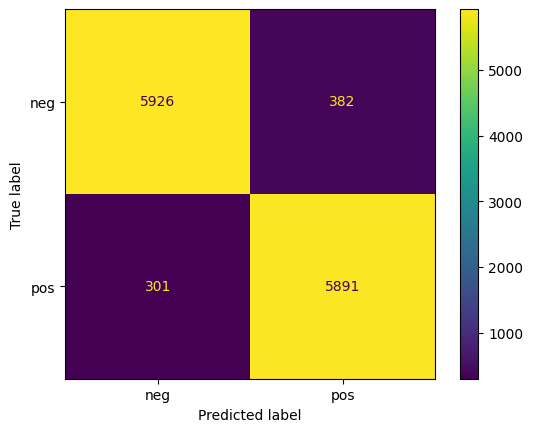

              precision    recall  f1-score   support

         neg       0.95      0.94      0.95      6308
         pos       0.94      0.95      0.95      6192

    accuracy                           0.95     12500
   macro avg       0.95      0.95      0.95     12500
weighted avg       0.95      0.95      0.95     12500



In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

labels = dataset_encoded['test']["labels"]

cm = confusion_matrix(labels, preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot() 
plt.show()

print(classification_report(labels, preds, target_names=unique_labels))

92% con bert uncased; 93% albert; 94% debert

In [24]:
trainer.evaluate()
trainer.save_model(output_path)
trainer.save_state()

100%|██████████| 782/782 [00:59<00:00, 13.19it/s]


In [25]:
from transformers import pipeline
pipe = pipeline('text-classification', model=output_path, truncation=True, max_length=512, device="cuda:0")

Device set to use cuda:0


In [26]:
#dataset_encoded["test"]

In [27]:
#dataset["test"]

In [28]:
#dataset_encoded['test']["text"]
#dataset['test']['text']

In [28]:
from transformers.pipelines.pt_utils import KeyDataset

predictions = []

for out in pipe(KeyDataset(dataset['test'], key="text")):  #perche non va con dataset_encoded['test']????????????????
    #print(out)
    pred = out['label']
    predictions.append(pred)

In [30]:
# predictions = []

# for n, movie in enumerate(test_df["text"]):
#     #print(str(n) + movie)
#     result = pipe(movie)
#     #print(f"Title: {title}")
#     #print(f"Output: {result[0]['label']}")
#     pred = result[0]['label']
#     print(result)
#     predictions.append(pred)

In [ ]:
le = LabelEncoder()
le.fit(predictions)

encoded_predictions = le.transform(predictions)

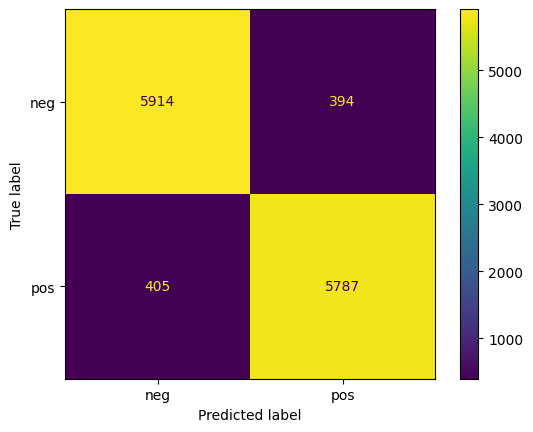

              precision    recall  f1-score   support

         neg       0.94      0.94      0.94      6308
         pos       0.94      0.93      0.94      6192

    accuracy                           0.94     12500
   macro avg       0.94      0.94      0.94     12500
weighted avg       0.94      0.94      0.94     12500



In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

labels = dataset_encoded['test']["labels"]

cm = confusion_matrix(labels, encoded_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot() 
plt.show()

print(classification_report(labels, encoded_predictions, target_names=unique_labels))